UI Demo

Before you hit `Run All`, check if you have already:

1. Started Solr and created the restaurantCore with docs_to_post.xml posted to it
2. Downloaded the helper text files categories.txt and neighborhoods.txt in the same directory as this notebook
3. pip installed tkinter, tkscrolledframe, geopy, tkintermapview

In [31]:
import tkinter as tk
import tkinter.ttk as ttk
from tkscrolledframe import ScrolledFrame
import requests
from datetime import datetime
from geopy.geocoders import Nominatim
import tkintermapview
import geocoder

In [32]:
solr_url = 'http://localhost:8983/solr'
collection_name = 'restaurantCore'  

In [33]:
categories = []
f = open('categories.txt', 'r')
for cat in f:
    categories.append(cat.rstrip())
categories = sorted(categories)
print(categories)
print(len(categories))

['American restaurant', 'Andhra restaurant', 'Argentinian restaurant', 'Asian fusion restaurant', 'Asian restaurant', 'Authentic Japanese restaurant', 'Bar', 'Bistro', 'Brewpub', 'Brunch restaurant', 'Cafe', 'Cantonese restaurant', 'Catalonian restaurant', 'Chicken restaurant', 'Chinese noodle restaurant', 'Chinese restaurant', 'Coffee shop', 'Conveyor belt sushi restaurant', 'Dim sum restaurant', 'European restaurant', 'Family restaurant', 'Fast food restaurant', 'Filipino restaurant', 'Fine dining restaurant', 'Fish and seafood restaurant', 'French restaurant', 'Fusion restaurant', 'German restaurant', 'Gluten-free restaurant', 'Greek restaurant', 'Gyudon restaurant', 'Halal restaurant', 'Hamburger restaurant', 'Hawker center', 'Hawker stall', 'Hong Kong style fast food restaurant', 'Hot pot restaurant', 'Indian Muslim restaurant', 'Indian restaurant', 'Indonesian restaurant', 'Italian restaurant', 'Izakaya restaurant', 'Japanese restaurant', 'Korean barbecue restaurant', 'Korean res

In [34]:
neighborhoods = []
f = open('neighborhoods.txt', 'r')
for n in f:
    neighborhoods.append(n.rstrip())
neighborhoods = sorted(neighborhoods)
print(neighborhoods)
print(len(neighborhoods))

['600@Toa Payoh', 'Ang Mo Kio', 'Bedok', 'Bishan', 'Boon Lay', 'Bukit Batok', 'Bukit Merah', 'Bukit Timah', 'Central Area', 'Changi', 'Chinatown', 'Clementi', 'Geylang', 'Holland Village', 'Jurong East', 'Jurong West', 'Kallang', 'Novena', 'Pasir Ris', 'Pioneer', 'Queenstown', 'Serangoon', 'Southern Islands', 'Sungei Kadut', 'Tampines', 'Tanglin', 'Tanjong Pagar', 'Tiong Bahru', 'Toa Payoh', 'Tuas', 'Western Islands', 'Western Water Catchment', 'Whampoa', 'Woodlands']
34


In [35]:
categories.insert(0, "NONE")
neighborhoods.insert(0, "NONE")

In [36]:
def query_solr(query, filters, sorts):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'
    
    # Define the base Solr query parameters
    params = {
        'q': '*:*',  # Filter by CategoryName
        'group': 'true',  # Enable grouping
        'group.field': 'restaurant',  # Group by restaurant field to avoid duplicates
        'group.limit': 1,  # Limit to one document per group (top document for each restaurant)
        'rows': 100,  # Limit number of results
        'debug': 'timing'  # Enable debug timing information
    }

    if query != '':
        params['q'] = query

    # If filters/sort specified, add/modify query params
    cat = filters['category']
    nei = filters['neighborhood']
    date = filters['date']
    if date != '':
        date += 'T00:00:00Z' # ISO 8601 format
    before_after = filters['before_after']
    guide = filters['guide']
    isLatLong = filters['isLatLong']
    getMyLoc = filters['getMyLoc']
    address = filters['address']
    rad = filters['rad']
    relevancy = sorts['relevancy']
    recency = sorts['recency']
    rating = sorts['rating']

    ### filters ###
    if cat != 'NONE':
        params['fq'] = f'categoryName:"{cat}"'
    if nei != 'NONE':
        if 'fq' in params:
            params['fq'] += f' AND neighborhood:"{nei}"'
        else:
            params['fq'] = f'neighborhood:"{nei}"'
    if date != '':
        if 'fq' in params:
            if before_after == 'before':
                params['fq'] += f' AND publishedAtDate:[* TO {date}]'
                params['sort'] = 'publishedAtDate desc'
            else:
                params['fq'] += f' AND publishedAtDate:[{date} TO *]'
                params['sort'] = 'publishedAtDate asc'
        else:
            if before_after == 'before':
                params['fq'] = f'publishedAtDate:[* TO {date}]'
                params['sort'] = 'publishedAtDate desc'
            else:
                params['fq'] = f'publishedAtDate:[{date} TO *]'
                params['sort'] = 'publishedAtDate asc'
    if guide != 'NONE':
        if 'fq' in params:
            params['fq'] += ' AND isLocalGuide:true'
        else:
            params['fq'] = 'isLocalGuide:true'
    if address != '' or getMyLoc == 1:
        if getMyLoc == 1:
            g = geocoder.ip('me')
            lat, lon = g.latlng
            address = f"{lat},{lon}"
        elif isLatLong == 0: # user input an address, need to convert to (lat,long)
            loc = Nominatim(user_agent='my-app')
            getLoc = loc.geocode(address)
            address = f"{getLoc.latitude},{getLoc.longitude}"
        # if 'fq' in params:
        #     params['fq'] += f' AND {{!geofilt sfield=LatLong pt={address} d={rad}}}'
        # else:
        #     params['fq'] = f'{{!geofilt sfield=LatLong pt={address} d={rad}}}'
        # Calculate bounding box coordinates for the given radius
        center_lat, center_lon = address.split(sep=',')
        center_lat = float(center_lat)
        center_lon = float(center_lon)
        lat_delta = float(rad) / 110.574  # 1 degree of latitude is approximately 110.574 km
        lon_delta = float(rad) / (111.32 * abs(center_lat))  # 1 degree of longitude varies depending on latitude
        lat_min = center_lat - lat_delta
        lat_max = center_lat + lat_delta
        lon_min = center_lon - lon_delta
        lon_max = center_lon + lon_delta

        if params['q'] == '*:*':
            params['q'] = f'LatLong:[{lat_min},{lon_min} TO {lat_max},{lon_max}]' # Match documents within the bounding box
        else:
            params['q'] += f' AND LatLong:[{lat_min},{lon_min} TO {lat_max},{lon_max}]'
    
    ### sorts ###
    if relevancy != 'NONE':
        if relevancy == 'most relevant':
            sort_order = 'desc'
        else:
            sort_order = 'asc'
        if 'sort' in params:
            params['sort'] += f', qualityScore {sort_order}'
        else:
            params['sort'] = f'qualityScore {sort_order}'
    if recency != 'NONE':
        timenow = datetime.now()
        timenow = timenow.isoformat()
        timenow += 'Z'
        if recency == 'newest':
            sort_order = 'desc'
        else:
            sort_order = 'asc'
        if 'fq' in params:
            params['fq'] += f' AND publishedAtDate:[* TO {timenow}]'
        else:
            params['fq'] = f'publishedAtDate:[* TO {timenow}]'
        if 'sort' in params:
            params['sort'] += f', publishedAtDate {sort_order}'
        else:
            params['sort'] = f'publishedAtDate {sort_order}'
    if rating != 'NONE':
        if rating == 'best':
            sort_order = 'desc'
        else:
            sort_order = 'asc'
        if 'sort' in params:
            params['sort'] += f', totalScore {sort_order}'
        else:
            params['sort'] = f'totalScore {sort_order}'

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        grouped_results = results['grouped']['restaurant']['groups']
        
        # Get execution time from debug info
        debug_info = results['debug']
        execution_time = debug_info['timing']['time']

        return response.status_code, execution_time, grouped_results

    else:
        return response.status_code, "null", "null"

In [37]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import LinearSegmentedColormap
from tkinter.font import Font


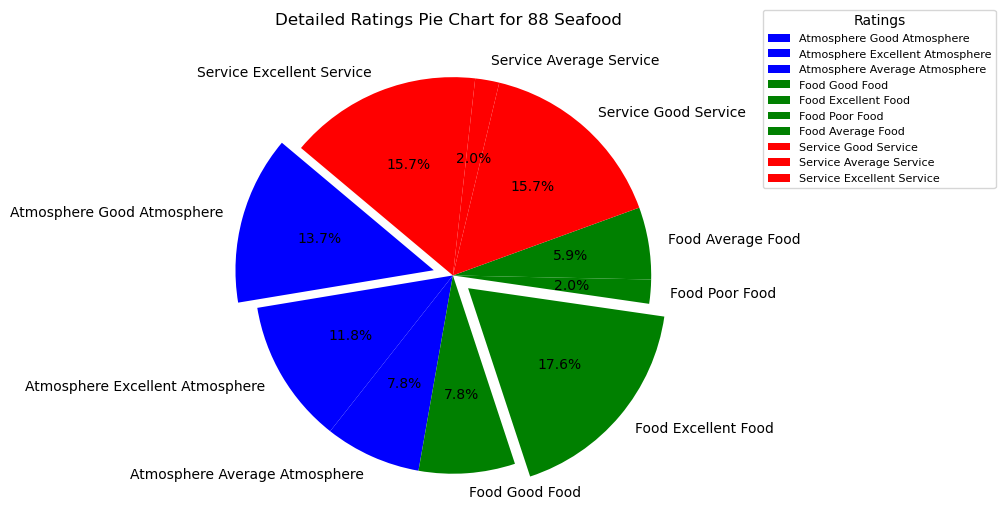

In [48]:
window = tk.Tk()
window.title("My Restaurant Search")

def query_reviews(solr_url, collection_name, restaurant_name):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch review text for a specific restaurant
    params = {
        'q': f'restaurant:"{restaurant_name}"',  # Query for a specific restaurant
        'fl': 'review',  # Fetch the review field
        'rows': 1000,  # Adjust based on expected number of reviews
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        reviews = [doc['review'] for doc in results['response']['docs'] if 'review' in doc]
        return " ".join(reviews)  # Combine all reviews into one text string
    else:
        print('Error:', response.status_code)
        return ""

def create_wordcloud_in_tk(window, text, restaurant_name):
    # Define the color map to use for the word cloud
    colormap = LinearSegmentedColormap.from_list('custom', ['orange', 'green', 'red', 'blue', 'purple'], N=256)
    stopwords = set(STOPWORDS)

    # Generate the word cloud image
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=150, 
        stopwords=stopwords, 
        collocations=False, 
        colormap=colormap,  # Using the colormap defined above
        normalize_plurals=True).generate(text)

    # Create the figure that will contain the plot
    fig = plt.Figure(figsize=(10, 5), dpi=100)
    plot = fig.add_subplot(1, 1, 1)
    plot.imshow(wordcloud, interpolation='bilinear')
    plot.axis('off')
    plot.set_title(f'Word Cloud for {restaurant_name}', pad=20)

    # Create a Canvas widget that will display the plot's Figure
    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

def query_detailed_ratings(solr_url, collection_name, restaurant_name):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch detailed ratings for a specific restaurant
    params = {
        'q': f'restaurant:"{restaurant_name}"',  # Query for a specific restaurant
        'fl': 'reviewDetailedRatingAtmosphere,reviewDetailedRatingFood,reviewDetailedRatingService',  # Fetch the detailed ratings fields
        'rows': 1000,  # Adjust based on expected number of reviews
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        documents = results['response']['docs']
        
        # Extract detailed ratings
        detailed_ratings = {
            'Atmosphere': [],
            'Food': [],
            'Service': []
        }
        for doc in documents:
            if 'reviewDetailedRatingAtmosphere' in doc:
                detailed_ratings['Atmosphere'].append(doc['reviewDetailedRatingAtmosphere'])
            if 'reviewDetailedRatingFood' in doc:
                detailed_ratings['Food'].append(doc['reviewDetailedRatingFood'])
            if 'reviewDetailedRatingService' in doc:
                detailed_ratings['Service'].append(doc['reviewDetailedRatingService'])
                
        return detailed_ratings
    else:
        print('Error:', response.status_code)
        return {}

def query_review_stars_for_restaurant(solr_url, collection_name, restaurant_name):
    # Define Solr query URL
    query_url = f'{solr_url}/{collection_name}/select'

    # Define Solr query parameters to fetch review stars for a specific restaurant
    params = {
        'q': f'restaurant:"{restaurant_name}"',  # Query for a specific restaurant
        'fl': 'review_stars',  # Fetch the review_stars field
        'rows': 1000,  # You might not need all results, adjust as necessary
    }

    # Send GET request to Solr
    response = requests.get(query_url, params=params)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse JSON response
        results = response.json()
        documents = results['response']['docs']
        
        # Extract review stars and convert them to integers
        review_stars = [int(doc['review_stars']) for doc in documents if 'review_stars' in doc]
        return review_stars
    else:
        print('Error:', response.status_code)
        return []

def create_pie_chart_in_tk(window, detailed_ratings, restaurant_name):
    # Prepare data for pie chart
    labels = []
    sizes = []
    colors = []
    explode = []  # to slightly separate the slices of the pie chart
    for rating_type, ratings in detailed_ratings.items():
        rating_set = set(ratings) - {'NaN'}  # Exclude 'NaN' from the set of ratings
        for rating in rating_set:
            if rating != 'NaN':  # Check to exclude 'NaN' ratings
                labels.append(f"{rating_type} {rating}")
                sizes.append(ratings.count(rating))
                explode.append(0.1 if ratings.count(rating) == max(sizes) else 0)  # Highlight the slice with the highest count
                if rating_type == 'Food':
                    colors.append('green')
                elif rating_type == 'Atmosphere':
                    colors.append('blue')
                elif rating_type == 'Service':
                    colors.append('red')
    
    # Only proceed if there are sizes for the pie chart
    if sizes:
        # Create the figure that will contain the plot
        fig, ax = plt.subplots()
        wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)

        # Beautify the pie chart
        plt.setp(autotexts, size=10)
        ax.axis('equal') 
        plt.title(f'Detailed Ratings Pie Chart for {restaurant_name}', y=1.05)

        # Create a legend
        ax.legend(wedges, [w.get_label() for w in wedges],
                  title="Ratings",
                  loc="center left",  # Position to the left
                  bbox_to_anchor=(0.9, 0.9),  # Slightly out to the right to fit within the figure
                  fontsize=8)

        # Create a Canvas widget that will display the plot's Figure
        canvas = FigureCanvasTkAgg(fig, master=window)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    else:
        # Display a message or log if no valid sizes are present
        print("No detailed ratings available to plot for", restaurant_name)

def create_histogram_in_tk(window, review_stars, restaurant_name):
    # Create the figure that will contain the plot
    fig = plt.Figure(figsize=(6, 4), dpi=100)
    plot = fig.add_subplot(1, 1, 1)

    # Plot the histogram on the Figure
    plot.hist(review_stars, bins=range(1, 7), align='left', color='blue', edgecolor='black')
    plot.set_title(f'Review Stars Histogram for {restaurant_name}')
    plot.set_xlabel('Review Stars Histogram')
    plot.set_ylabel('Number of Reviews')
    plot.set_xticks(range(1, 6))

    # Create a Canvas widget that will display the plot's Figure
    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    
def fetch_restaurant_details(restaurant_name):
    solr_core = "restaurantCore"
    # Clean up the restaurant name to match the Solr field
    # For instance, if the restaurant name in the listbox is "88 Seafood (Chinese restaurant)"
    # We extract "88 Seafood" to use in the Solr query
    clean_restaurant_name = restaurant_name.split('(')[0].strip()
    query = f'restaurant:"{clean_restaurant_name}"'
    solr_query_url = f"http://localhost:8983/solr/{solr_core}/select?q={query}&wt=json"
    
    response = requests.get(solr_query_url, headers={'Content-Type': 'application/json'})
    try:
        data = response.json()
    except ValueError:
        print("Invalid JSON response from Solr server")
        return None

    # Assuming the Solr response contains the restaurant details in the 'docs' key
    if 'response' in data and 'docs' in data['response'] and len(data['response']['docs']) > 0:
        return data['response']['docs'][0]
    else:
        return None

def on_review_select(event):
    selection = event.widget.curselection()
    if selection:
        index = selection[0]
        restaurant_name_with_cuisine = event.widget.get(index)
        clean_restaurant_name = restaurant_name_with_cuisine.split('(')[0].strip()  # Assuming you need to clean the name

        # Fetch the details for the selected restaurant from Solr
        restaurant_details = fetch_restaurant_details(clean_restaurant_name)
        
        if restaurant_details:
            # Open a new window with detailed info
            review_stars = query_review_stars_for_restaurant(solr_url, collection_name, clean_restaurant_name)
            detailed_ratings = query_detailed_ratings(solr_url, collection_name, clean_restaurant_name)
            reviews_text = query_reviews(solr_url, collection_name, clean_restaurant_name)
            detail_window = tk.Toplevel(window)
            detail_window.title(f"Details of {clean_restaurant_name}")
            detail_window.geometry('1000x600')  # Adjust size as needed

            my_font = Font(family="Helvetica", size=14)

            # Use a notebook to organize the plots into tabs
            notebook = ttk.Notebook(detail_window)

            # Create a frame for the text details
            text_frame = ttk.Frame(notebook)
            tk.Label(text_frame, text=f"Restaurant: {restaurant_details['restaurant']}", font=my_font).pack()
            tk.Label(text_frame, text=f"Address: {restaurant_details['address']}", font=my_font).pack()
            tk.Label(text_frame, text=f"Neighborhood: {restaurant_details['neighborhood']}", font=my_font).pack()
            notebook.add(text_frame, text='Details')

            # If review stars are available, create the histogram tab
            if review_stars:
                histogram_frame = ttk.Frame(notebook)
                create_histogram_in_tk(histogram_frame, review_stars, restaurant_details['restaurant'])
                notebook.add(histogram_frame, text='Review stars')

            # If detailed ratings are available, create the pie chart tab
            if detailed_ratings:
                pie_chart_frame = ttk.Frame(notebook)
                create_pie_chart_in_tk(pie_chart_frame, detailed_ratings, restaurant_details['restaurant'])
                notebook.add(pie_chart_frame, text='Detailed ratings')

            # If reviews text is available, create the word cloud tab
            if reviews_text:
                wordcloud_frame = ttk.Frame(notebook)
                create_wordcloud_in_tk(wordcloud_frame, reviews_text, restaurant_details['restaurant'])
                notebook.add(wordcloud_frame, text='Word Cloud')

            notebook.pack(expand=True, fill='both')  # Pack the notebook last
        else:
            print(f"No details found for restaurant: {clean_restaurant_name}")


def fetch_spell_check_suggestions(search_term):
    search_field = "review"
    encoded_search_term = requests.utils.quote(search_term)
    query = f"{search_field}:{encoded_search_term}"
    solr_core = "restaurantCore"
    solr_query_url = f"http://localhost:8983/solr/{solr_core}/select?q={query}&spellcheck=true&wt=json"

    response = requests.get(solr_query_url, headers={'Content-Type': 'application/json'})
    try:
        data = response.json()
    except ValueError:
        print("Invalid JSON response from Solr server")
        return []

    suggestions = []
    if 'spellcheck' in data and 'suggestions' in data['spellcheck']:
        for i in range(1, len(data['spellcheck']['suggestions']), 2):
            suggestion_info = data['spellcheck']['suggestions'][i]
            if 'suggestion' in suggestion_info:
                suggestions.extend(suggestion_info['suggestion'])

    return suggestions

def display_query_results():
    query = entry.get()
    cat = categories_click.get()
    nei = neighborhoods_click.get()
    date = date_iso.get()
    before_after = date_click.get()
    guide = guide_click.get()
    isLatLong = check_button1.get()
    getMyLoc = check_button2.get()
    address = add_entry.get()
    rad = radius.get()
    spell_check_suggestions = fetch_spell_check_suggestions(query)
    spell_check_label.config(text=f"Did you mean: {', '.join(spell_check_suggestions)}")
    filters = {
        'category':cat,
        'neighborhood':nei,
        'date':date,
        'before_after':before_after,
        'guide':guide,
        'isLatLong':isLatLong,
        'getMyLoc':getMyLoc,
        'address':address,
        'rad':rad
    }
    relevancy = relevant_click.get()
    recency = recency_click.get()
    rating = rating_click.get()
    sorts = {
        'relevancy':relevancy,
        'recency':recency,
        'rating':rating
    }
    query_str = query 
    if cat != 'NONE':
        query_str += f" + filter:{cat}"
    if nei != 'NONE':
        query_str += f" + filter:{nei}"
    if date != '':
        query_str += f" + filter:{before_after} {date}"
    if guide != 'NONE':
        query_str += f" + filter:isLocalGuide"
    if address != '':
        query_str += f" + filter:{address} within {rad}km"
    if getMyLoc == 1:
        query_str += f" +filter:my location within {rad}km"

    sort_str = ''
    if relevancy != 'NONE':
        sort_str += f" + sort:{relevancy}"
    if recency != 'NONE':
        sort_str += f" + sort:{recency}"
    if rating != 'NONE':
        sort_str += f" +sort:{rating}"

    status, execution_time, grouped_results = query_solr(query, filters, sorts)

    # clear the results_frame each time user search
    for widget in inner_frame.winfo_children():
        widget.destroy()
    for widget in map_frame.winfo_children():
        widget.destroy()

    if status != 200:
        ttk.Label(inner_frame, text=f"Error: {status}").grid(row=0, column=0)
    else:
        out = ttk.Label(inner_frame, text=f"{len(grouped_results)} Results with query: {query_str}")
        out.grid(row=0, column=0)
        out = ttk.Label(inner_frame, text=f"Sorted by (if any): {sort_str}")
        out.grid(row=1, column=0)
        out = ttk.Label(inner_frame, text=f"Execution Time: {execution_time} ms")
        out.grid(row=2, column=0)
        i = 3

        if address != '' or getMyLoc==1:
            
            # this is to set marker for current location / specified location
            if getMyLoc == 1:
                g = geocoder.ip('me')
                lat, lon = g.latlng
                cur_latlong = [lat, lon]
            elif isLatLong == 0: # user input an address, need to convert to (lat,long)
                loc = Nominatim(user_agent='my-app')
                getLoc = loc.geocode(address)
                cur_latlong = [getLoc.latitude, getLoc.longitude]
            else:
                lat, lon = address.split(',')
                cur_latlong = [float(lat), float(lon)]

            restaurants_locations = [(doc['doclist']['docs'][0]['restaurant'], tuple(map(float, doc['doclist']['docs'][0]['LatLong'].split(',')))) for doc in grouped_results]
            map_widget = tkintermapview.TkinterMapView(map_frame, width=350, height=250, corner_radius=0)
            map_widget.place(relx=0.5, rely=0.5, anchor=tk.CENTER)
            for name, (lat, lon) in restaurants_locations:
                map_widget.set_position(lat, lon, marker=True).set_text(name)
            map_widget.set_position(cur_latlong[0], cur_latlong[1], marker=True, marker_color_circle='green', marker_color_outside='blue')
            map_widget.set_zoom(12)
            map_widget.grid(row=i, column=0)

        for group in grouped_results:
            restaurant_doc = group['doclist']['docs'][0]
            if restaurant_doc['classPrediction']==1:
                senti_emoji = '😊'
            else:
                senti_emoji = '☹️'
            if restaurant_doc['isLocalGuide']==True:
                reviewer_emoji = '👤🚩'
            else:
                reviewer_emoji = '👤'

            out = tk.Listbox(inner_frame, height=5, width=120)
            out.insert(0, f"{restaurant_doc['restaurant']} ({restaurant_doc['categoryName']})")
            out.insert(1, f"Avg rating: {restaurant_doc['totalScore']}⭐ out of {restaurant_doc['reviewsCount']} reviews")
            out.insert(2, f"{reviewer_emoji}{restaurant_doc['reviewer']} rated: {restaurant_doc['review_stars']}⭐ sentiment: {senti_emoji}")
            out.insert(3, f"Review published at {restaurant_doc['publishedAtDate']} ({restaurant_doc['likesCount']}👍): {restaurant_doc['review']}")
            out.insert(4, f"Address: {restaurant_doc['address']}")
            out.bind('<<ListboxSelect>>', on_review_select) # on review select
            out.grid(row=i+1, column=0)
            i += 1

# The box where user inputs query
entry = tk.Entry(window, width=65)
entry.grid(row=0, column=0, padx=10, pady=10)

# This is the frame which bounds all results of user queries
# results_frame = ttk.LabelFrame(window, text="Results")
results_frame = ScrolledFrame(window, width=700, height=450)
results_frame.grid(row=1, column=2, rowspan=2, padx=10, pady=10)
results_frame.bind_arrow_keys(window)
# results_frame.bind_scroll_wheel(window)
inner_frame = results_frame.display_widget(tk.Frame)
map_frame = tk.Frame(window, padx=10, pady=10)
map_frame.grid(row=2, column=0)

################ Filters #####################

# This is the frame which bounds all filters
filters_frame = ttk.LabelFrame(window, text="Refine search")
filters_frame.grid(row=1, column=0)

ttk.Label(filters_frame, text="----- FILTER BY -----").grid(row=0, column=1)

# filter by CATEGORY
categories_click = tk.StringVar()
categories_cb = ttk.Combobox(filters_frame, textvariable=categories_click)
categories_cb['values'] = tuple(categories)
categories_cb.current(0) # set default category to NONE
ttk.Label(filters_frame, text="Category: ").grid(row=1, column=0)
categories_cb.grid(row=1, column=1)

# filter by NEIGHBORHOOD
neighborhoods_click = tk.StringVar()
neighborhoods_cb = ttk.Combobox(filters_frame, textvariable=neighborhoods_click)
neighborhoods_cb['values'] = tuple(neighborhoods)
neighborhoods_cb.current(0) # set default neighborhood to NONE
ttk.Label(filters_frame, text="Neighborhood: ").grid(row=2, column=0)
neighborhoods_cb.grid(row=2, column=1)

# filter by DATE
date_click = tk.StringVar()
date_cb = ttk.Combobox(filters_frame, textvariable=date_click)
date_cb['values'] = ('before', 'after')
date_cb.current(0) # set default date to before
ttk.Label(filters_frame, text='Published Date (yyyy-mm-dd): ').grid(row=3, column=0)
date_cb.grid(row=3, column=1)
date_iso = tk.Entry(filters_frame, width=20)
# date_iso.insert(0, 'NONE')
date_iso.grid(row=3, column=2)

# filter by LOCAL GUIDE
guide_click = tk.StringVar()
guide_cb = ttk.Combobox(filters_frame, textvariable=guide_click)
guide_cb['values'] = ('NONE', 'yes')
guide_cb.current(0) # set default is local guide to NONE i.e. no preference
ttk.Label(filters_frame, text='Recc from local guide?: ').grid(row=4, column=0)
guide_cb.grid(row=4, column=1)

# filter by DISTANCE
ttk.Label(filters_frame, text="Distance from given location: ").grid(row=5, column=0)
check_button1 = tk.IntVar()
check_latlong = ttk.Checkbutton(filters_frame, text="Using (lat,long)?", variable=check_button1, onvalue=1, offvalue=0)
check_latlong.grid(row=5, column=1)
add_entry = tk.Entry(filters_frame, width=20)
add_entry.grid(row=5, column=2)
check_button2 = tk.IntVar()
check_myloc = ttk.Checkbutton(filters_frame, text="Help me get my location!", variable=check_button2, onvalue=1, offvalue=0)
check_myloc.grid(row=6, column=1)
ttk.Label(filters_frame, text='Within (x)km: ').grid(row=7, column=0)
radius = tk.Entry(filters_frame, width=5)
radius.insert(0, '5') # set default 5km radius
radius.grid(row=7, column=1)


################### Sorts ##########################

# This is the frame which bounds all sorts
# sorts_frame = ttk.LabelFrame(window, text="Sort by")
# sorts_frame.grid(row=2, column=0)

ttk.Label(filters_frame, text="----- SORT BY -----").grid(row=8, column=1)

# sort by RELEVANCY (qualityScore)
relevant_click = tk.StringVar()
relevant_cb = ttk.Combobox(filters_frame, textvariable=relevant_click)
relevant_cb['values'] = ('NONE', 'most relevant', 'least relevant')
relevant_cb.current(0)
ttk.Label(filters_frame, text='Relevancy: ').grid(row=9, column=0)
relevant_cb.grid(row=9, column=1)

# sort by RECENCY
recency_click = tk.StringVar()
recency_cb = ttk.Combobox(filters_frame, textvariable=recency_click)
recency_cb['values'] = ('NONE', 'newest', 'oldest')
recency_cb.current(0)
ttk.Label(filters_frame, text='Recency: ').grid(row=10, column=0)
recency_cb.grid(row=10, column=1)

# sort by RATING (totalScore)
rating_click = tk.StringVar()
rating_cb = ttk.Combobox(filters_frame, textvariable=rating_click)
rating_cb['values'] = ('NONE', 'best', 'worst')
rating_cb.current(0)
ttk.Label(filters_frame, text='Rating: ').grid(row=11, column=0)
rating_cb.grid(row=11, column=1)

###################################################

search_button = ttk.Button(window, text="Search", command=display_query_results)
search_button.grid(row=0, column=1, padx=10, pady=10)

did_you_mean_label = ttk.Label(window, text="Did you mean:")
did_you_mean_label.grid(row=0, column=2, columnspan=2, padx=10, pady=0, sticky='W')

spell_check_label = ttk.Label(window, text="")
spell_check_label.grid(row=0, column=2, columnspan=2, padx=10, pady=0, sticky='W')

window.mainloop()